# Minimal Effort Learning Model

## 1. Initial Set up

In [1]:
import nengo
import pickle
import numpy as np
import pandas as pd
from nengo.ensemble import Ensemble
from nengo.connection import Connection
from nengo.node import Node
import matplotlib.pyplot as plt

First we import the raw data from MT_S2

In [3]:
# Change 'monkey' variable to the desired monkey dataset: MM_S1, MT_S1, MT_S2, MT_S3
monkey = "MM_S2"

# Datapath to get the raw data file (Stored in DataExtraction)
datafile_path = "./../../Data Extraction/Extracted Data/MT_S1_raw.csv"      # r"..\\..\\Data Extraction\\Extracted Data\\"+monkey+"_raw.csv"

df = pd.read_csv(datafile_path)

headers = df.columns.tolist()
n_neurons = sum("Neuron" in string for string in headers)
print(headers)

# getting the activity matrix
neuron_columns = [col for col in df.columns if col.startswith('Neuron')]
activity_matrix = df[neuron_columns]

# velocity data
velocity_matrix = df[["x_velocity", "y_velocity"]]
# acceleration data
acceleration_matrix = df[["x_acceleration", "y_acceleration"]]

# transpose the data
activity_matrix_t = activity_matrix.transpose().to_numpy()
velocity_matrix_t = velocity_matrix.transpose().to_numpy()
acceleration_matrix_t = acceleration_matrix.transpose().to_numpy()

print(df["Timestamp"])

['Unnamed: 0', 'Timestamp', 'Neuron1', 'Neuron2', 'Neuron3', 'Neuron4', 'Neuron5', 'Neuron6', 'Neuron7', 'Neuron8', 'Neuron9', 'Neuron10', 'Neuron11', 'Neuron12', 'Neuron13', 'Neuron14', 'Neuron15', 'Neuron16', 'Neuron17', 'Neuron18', 'Neuron19', 'Neuron20', 'Neuron21', 'Neuron22', 'Neuron23', 'Neuron24', 'Neuron25', 'Neuron26', 'Neuron27', 'Neuron28', 'Neuron29', 'Neuron30', 'Neuron31', 'Neuron32', 'Neuron33', 'Neuron34', 'Neuron35', 'Neuron36', 'Neuron37', 'Neuron38', 'Neuron39', 'Neuron40', 'Neuron41', 'Neuron42', 'Neuron43', 'Neuron44', 'Neuron45', 'Neuron46', 'Neuron47', 'Neuron48', 'Neuron49', 'x_velocity', 'y_velocity', 'x_acceleration', 'y_acceleration']
0           1.000
1           1.001
2           1.002
3           1.003
4           1.004
           ...   
800996    801.996
800997    801.997
800998    801.998
800999    801.999
801000    802.000
Name: Timestamp, Length: 801001, dtype: float64


In [35]:
print(acceleration_matrix)
print("--")
print(acceleration_matrix_t)

        x_acceleration  y_acceleration
0             0.000000        0.000000
1          -431.367181     -777.769207
2          -376.327825     -677.758858
3          -321.256026     -580.463978
4          -266.557306     -488.219710
...                ...             ...
800996       44.106049       63.620254
800997       48.073401       39.704196
800998       50.127855       14.883816
800999       50.463380       -9.880212
801000       49.361868      -33.751317

[801001 rows x 2 columns]
--
[[   0.         -431.36718094 -376.32782501 ...   50.12785455
    50.46337957   49.36186783]
 [   0.         -777.76920689 -677.75885754 ...   14.88381606
    -9.88021212  -33.75131673]]


## 2. Building the model

Setting the model parameters

In [4]:
spikes = activity_matrix_t 
scalar = np.max(acceleration_matrix_t)
target_out = acceleration_matrix_t/scalar 

In [21]:
#transforming the data (i.e anything 3 standard dev above the mean will be cut off)
import numpy as np 

#Finding how many columns of acceleration there is then use that for counting our timestamps
timestamps= np.arange(acceleration_matrix_t.shape[1])

original_data_x= acceleration_matrix_t[0] #the 0th row would correspond to x-acceleration 
original_data_y= acceleration_matrix_t[1] #the 0th row would correspond to y-acceleration 

#defining the maximum threshold (3 standard deviations from the mean)
threshold= 4*np.std(acceleration_matrix_t)

transformed_acceleration_x= np.clip(original_data_x, -threshold, threshold)
transformed_acceleration_y= np.clip(original_data_y, -threshold, threshold)


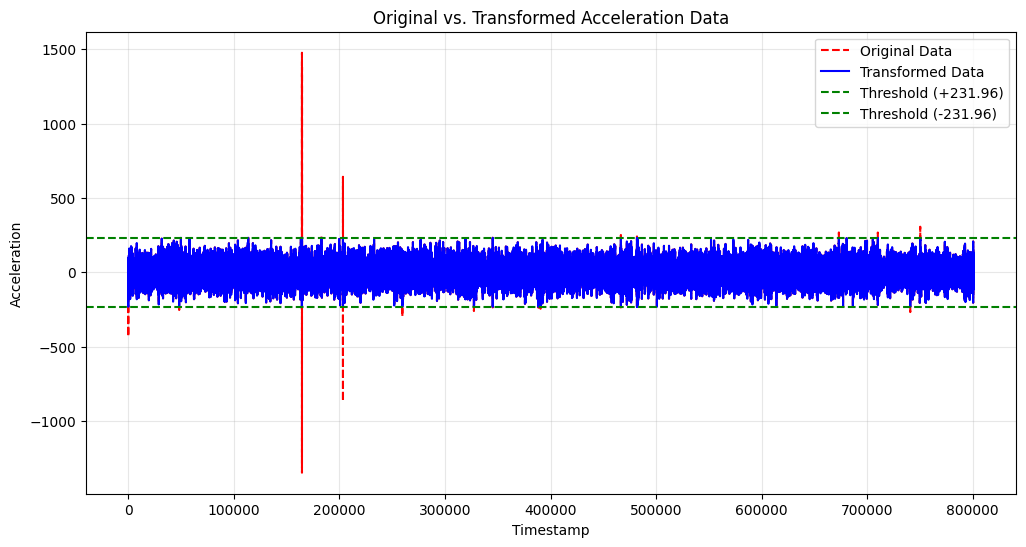

In [22]:

# Plot the data
plt.figure(figsize=(12, 6))

# Plot original data
plt.plot(timestamps, original_data_x, label="Original Data", color='red', linestyle='--')

# Plot clipped data
plt.plot(timestamps, transformed_acceleration_x, label="Transformed Data", color='blue', linestyle='-')

# Highlight the threshold bounds
plt.axhline(threshold, color='green', linestyle='--', label=f"Threshold (+{threshold:.2f})")
plt.axhline(-threshold, color='green', linestyle='--', label=f"Threshold (-{threshold:.2f})")

# Add labels, legend, title
plt.xlabel("Timestamp")
plt.ylabel("Acceleration")
plt.title("Original vs. Transformed Acceleration Data")
plt.legend(loc="upper right")
plt.grid(alpha=0.3)

# Show the plot
plt.show()


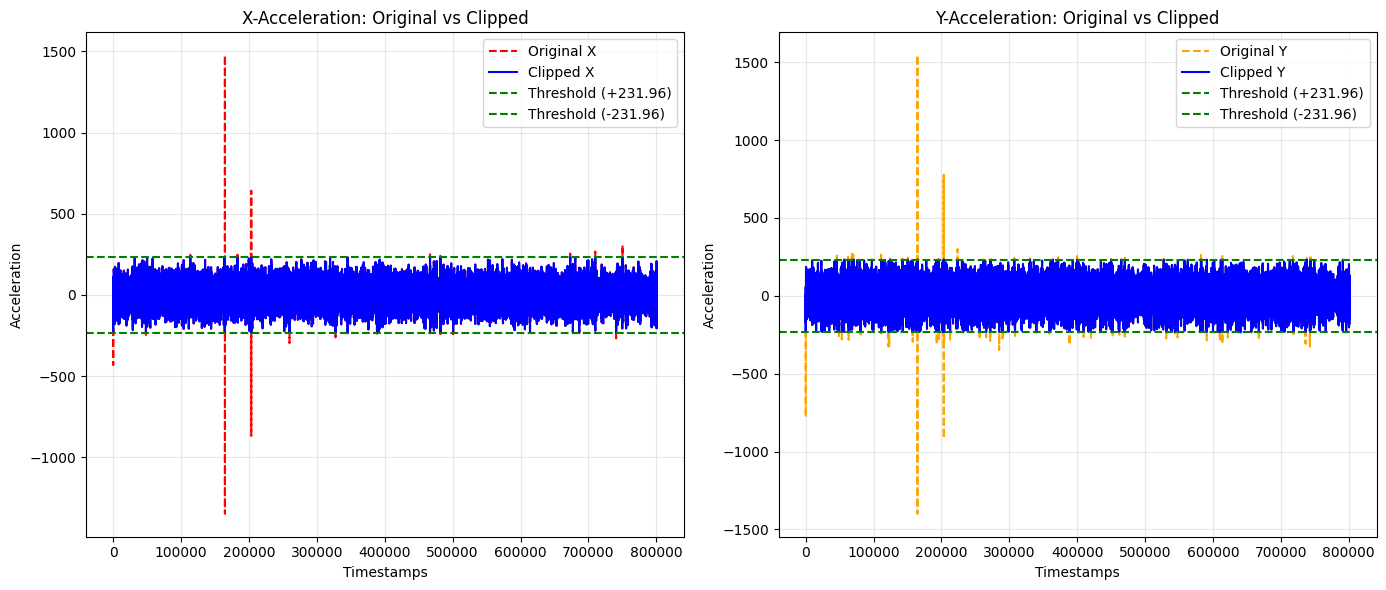

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].plot(timestamps, original_data_x, label="Original X", color='red', linestyle='--')
axes[0].plot(timestamps, transformed_acceleration_x, label="Clipped X", color='blue', linestyle='-')
axes[0].axhline(threshold, color='green', linestyle='--', label=f"Threshold (+{threshold:.2f})")
axes[0].axhline(-threshold, color='green', linestyle='--', label=f"Threshold (-{threshold:.2f})")
axes[0].set_title("X-Acceleration: Original vs Clipped")
axes[0].set_xlabel("Timestamps")
axes[0].set_ylabel("Acceleration")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Y-Acceleration plot
axes[1].plot(timestamps, original_data_y, label="Original Y", color='orange', linestyle='--')
axes[1].plot(timestamps, transformed_acceleration_y, label="Clipped Y", color='blue', linestyle='-')
axes[1].axhline(threshold, color='green', linestyle='--', label=f"Threshold (+{threshold:.2f})")
axes[1].axhline(-threshold, color='green', linestyle='--', label=f"Threshold (-{threshold:.2f})")
axes[1].set_title("Y-Acceleration: Original vs Clipped")
axes[1].set_xlabel("Timestamps")
axes[1].set_ylabel("Acceleration")
axes[1].legend()
axes[1].grid(alpha=0.3)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

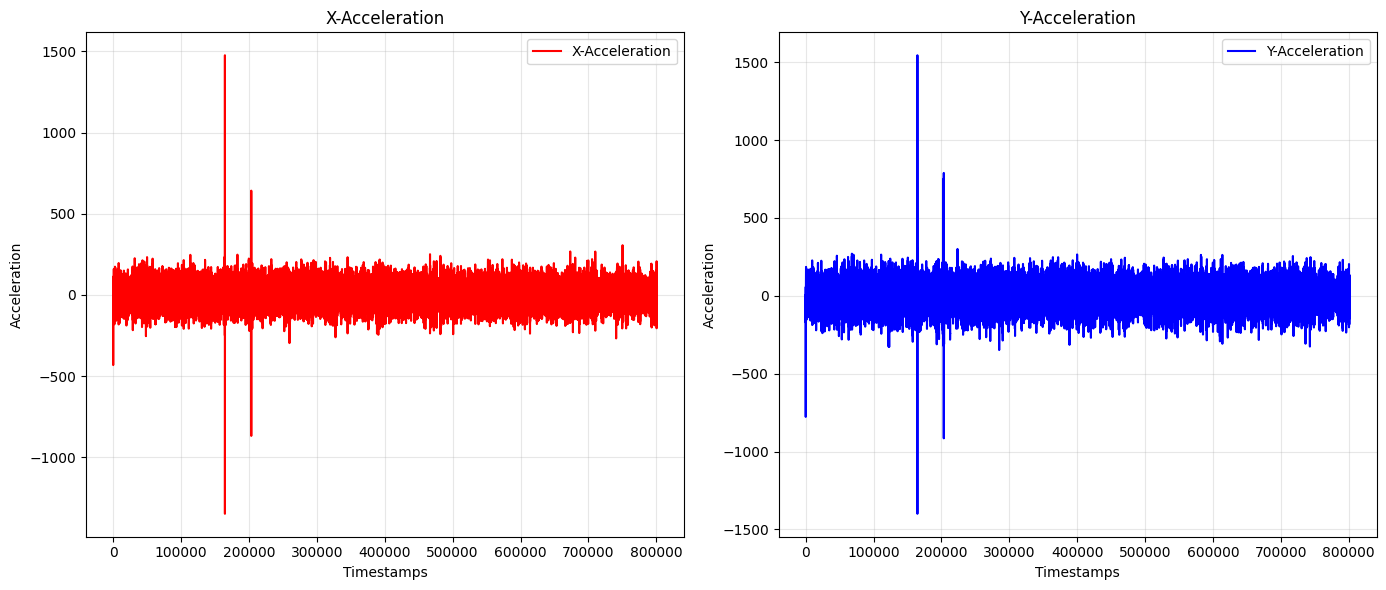

In [15]:
# X-Acceleration plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].plot(timestamps, original_data_x, label="X-Acceleration", color='red', linestyle='-')
axes[0].set_title("X-Acceleration")
axes[0].set_xlabel("Timestamps")
axes[0].set_ylabel("Acceleration")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Y-Acceleration plot
axes[1].plot(timestamps, original_data_y, label="Y-Acceleration", color='blue', linestyle='-')
axes[1].set_title("Y-Acceleration")
axes[1].set_xlabel("Timestamps")
axes[1].set_ylabel("Acceleration")
axes[1].legend()
axes[1].grid(alpha=0.3)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [34]:
transformed_acceleration_matrix = np.vstack((transformed_acceleration_x, transformed_acceleration_y))

# Print the matrix
print(transformed_acceleration_matrix)

# Get the number of rows and columns
rows, cols = transformed_acceleration_matrix.shape

print(f'Rows: {rows}, Columns: {cols}')

print(acceleration_matrix_t)

[[   0.         -231.95603613 -231.95603613 ...   50.12785455
    50.46337957   49.36186783]
 [   0.         -231.95603613 -231.95603613 ...   14.88381606
    -9.88021212  -33.75131673]]
Rows: 2, Columns: 801001
[[   0.         -431.36718094 -376.32782501 ...   50.12785455
    50.46337957   49.36186783]
 [   0.         -777.76920689 -677.75885754 ...   14.88381606
    -9.88021212  -33.75131673]]


In [33]:
print(acceleration_matrix_t.shape)

(2, 801001)


In [60]:
spikes =activity_matrix_t
scalar = np.max(transformed_acceleration_matrix)
target_out =transformed_acceleration_matrix/scalar 

# Model Information
dt = 0.001
dti = 1/dt
spikes = spikes*dti

# Model Parameters
n_ensemble_neurons = 3000
ensemble_radius = 1     # ? Represents the range of values for the neurons?
ensemble_synapse = 0.025
probe_synapse = 0.01

running_time = 300 # How long the model should run for
training_time = 0.8*running_time # WHen does the model stop learning


Building the nengo network

In [61]:
with nengo.Network() as model:
    in_node = nengo.Node(lambda t: spikes[:,int(t / dt) - 1])
    
    target_node = nengo.Node(lambda t: target_out[:,int(t / dt) - 1]) # expected kinematic output
    inhib_node = nengo.Node(output=lambda t: t >= training_time)

    rep_ens = nengo.Ensemble(n_ensemble_neurons, n_neurons, ensemble_radius)
    out_ens = nengo.Ensemble(n_ensemble_neurons, 2, ensemble_radius)
    err_ens = nengo.Ensemble(n_ensemble_neurons, 2, ensemble_radius)

    in_rep_con = nengo.Connection(in_node, rep_ens, ensemble_synapse) # Acts as a low-pass for the spike input
    rep_out_con = nengo.Connection(rep_ens, out_ens, function=lambda x: [0, 0], learning_rule_type=nengo.PES(learning_rate=2e-4))
    out_err_con = nengo.Connection(out_ens, err_ens)
    tar_err_con = nengo.Connection(target_node, err_ens, transform=-1)
    err_lrn_con = nengo.Connection(err_ens, rep_out_con.learning_rule) # Connects error ensemble value to learning rule -- analogous to how backprop uses error to follow stochastic gradient in training
    inhib_lrn_con = nengo.Connection(inhib_node, err_ens.neurons, transform=-20 * np.ones((err_ens.n_neurons, 1))) # Inhibit error ensemble once training is done to prevent weight changes after training_time

    p_out = nengo.Probe(out_ens, synapse=probe_synapse)
    p_err = nengo.Probe(err_ens, synapse=probe_synapse)




## 3. Visualizing results


In [62]:
save_file = "./melm_params"
with nengo.Simulator(model, dt=dt, seed=0) as sim:
    sim.run(running_time)

Build finished in 0:00:11.                                                      
Simulation finished in 0:06:45.                                                 


In [63]:
# Save the model (lol this doesn't work)
# with open('simulation.pkl', 'wb') as file:
#     pickle.dump(sim.data, file)


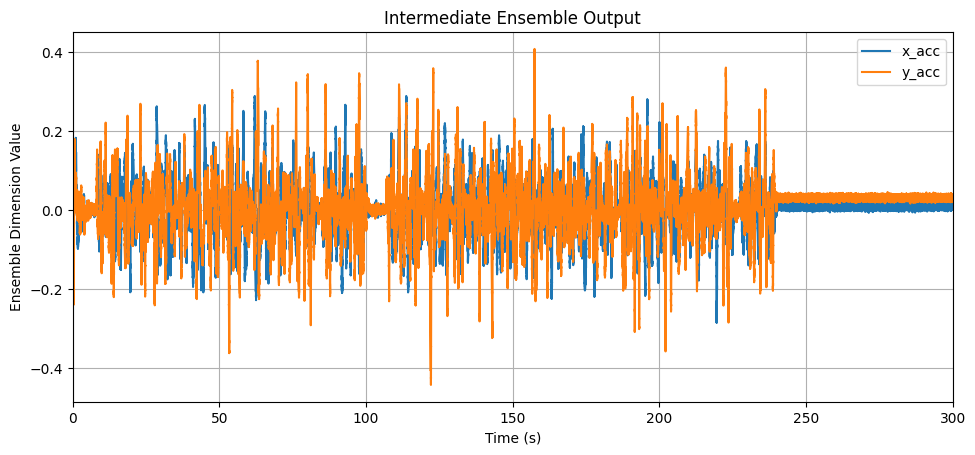

In [64]:
# For the outputs
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_out])
pl.set_title("Intermediate Ensemble Output")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["x_acc", "y_acc"])
pl.grid()

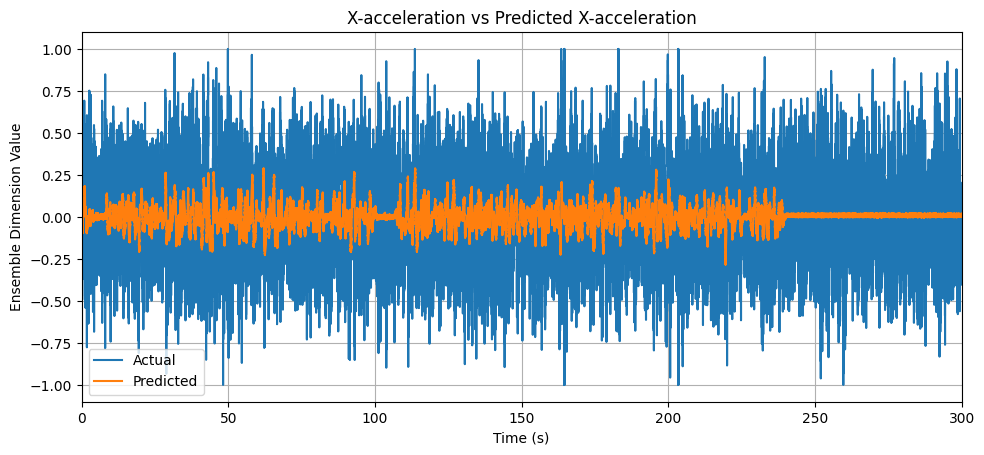

In [65]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), target_out[0, 0:len(sim.trange())])
pl.plot(sim.trange(), sim.data[p_out][:, 0])
pl.set_title("X-acceleration vs Predicted X-acceleration")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["Actual", "Predicted"])
pl.grid()

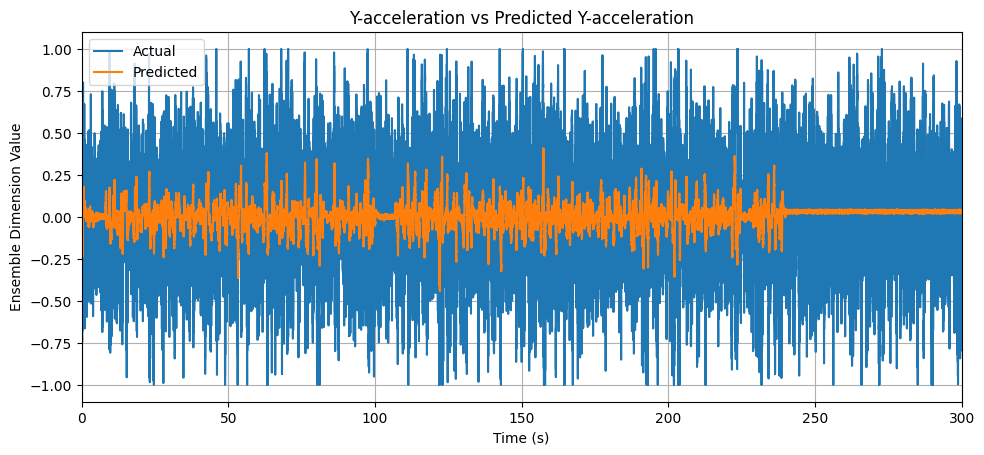

In [66]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), target_out[1, 0:len(sim.trange())])
pl.plot(sim.trange(), sim.data[p_out][:, 1])
pl.set_title("Y-acceleration vs Predicted Y-acceleration")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["Actual", "Predicted"])
pl.grid()

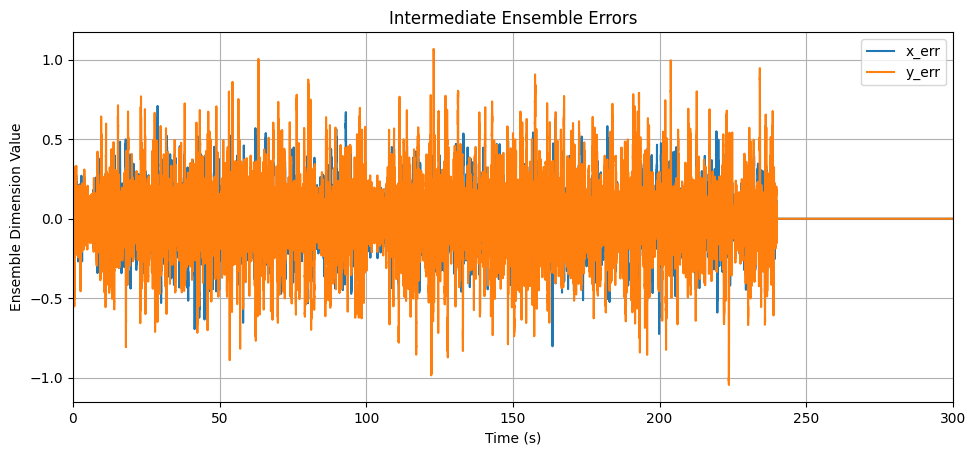

In [67]:
# For the errors
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_err])
pl.set_title("Intermediate Ensemble Errors")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["x_err", "y_err"])
pl.grid()

## 4. Evaluation

In [68]:
def GetErrors(truth, predicted):
    # ax := ground truth x acceleration, ay := ground truth y acceleration
    # sim.data[p_a] := 2-dimensional output with 0th dimension corresponding to x and 1st dimension corresponding to y
    e_mae = np.sum(np.abs(truth - predicted)) / truth.shape[0]
    e_rmse = np.sqrt(np.sum(np.power(truth - predicted, 2)) / truth.shape[0])
    print("Mean Absolute Error: " + str(e_mae))
    print("Root Mean_Squared Error: " + str(e_rmse))

In [69]:
# X-Acceleration Error
print("X-Acceleration Error")
GetErrors(target_out[0, 0:len(sim.trange())], sim.data[p_out][:, 0])
print("")
 
# Y-Acceleration Error
print("Y-Acceleration Error")
GetErrors(target_out[1, 0:len(sim.trange())], sim.data[p_out][:, 1])
print("")

X-Acceleration Error
Mean Absolute Error: 0.17549610422959044
Root Mean_Squared Error: 0.2263744380057035

Y-Acceleration Error
Mean Absolute Error: 0.21465452569158117
Root Mean_Squared Error: 0.28239916460768283

